# Import Libraries

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c playground-series-s4e8

 83% 68.0M/82.3M [00:00<00:00, 141MB/s]
100% 82.3M/82.3M [00:00<00:00, 123MB/s]


In [3]:
!pip install --upgrade catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.8 MB/s eta 0:00:00


In [4]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# https://www.kaggle.com/code/kirankunapuli/ieee-fraud-lightgbm-with-gpu/notebook

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder,RobustScaler
from scipy.stats import mode

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from datetime import datetime
import xgboost as xgb
import math
import csv

# Loading Data

In [6]:
!unzip /content/playground-series-s4e8.zip

Archive:  /content/playground-series-s4e8.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
columns_to_be_removed = ["id"]
CATEGORICAL_MAIN_GROUP = "cap-color"
CUT_OFF = 99.99
RANDOM_STATE=42
TEST_SIZE=0.15
EARLY_STOPPING_ROUNDS=20
FILE_NAME = "submission.csv"
INCLUDE_MINMAX_SCALE=True
INCLUDE_LOG_SCALE=True

In [8]:
train_df = pd.read_csv("/content/train.csv", index_col='id')
orig_df = pd.read_csv("/content/secondary_data.csv", sep=";")
test_df = pd.read_csv("/content/test.csv", index_col='id')

In [9]:
train_df = pd.concat([train_df, orig_df], ignore_index=True)

In [10]:
def plot_categoricals(df):

    categorical_columns = df.select_dtypes(include=["object"]).columns

    n_cols = 3
    n_rows = math.ceil(len(categorical_columns) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    fig.suptitle('Distribution of Unique Values in Categorical Columns', fontsize=20)

    for i, col in enumerate(categorical_columns):
        row = i // n_cols
        col_pos = i % n_cols

        value_counts = df[col].value_counts()
        axs[row, col_pos].bar(value_counts.index, value_counts.values, color=plt.cm.tab20.colors)
        axs[row, col_pos].set_title(col)
        axs[row, col_pos].tick_params(axis='x', rotation=90)
        axs[row, col_pos].set_ylabel('Count')
        axs[row, col_pos].set_xlabel('Category')
        axs[row, col_pos].set_yscale('log')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axs.flat[j])
    plt.show()

In [11]:
common_columns = train_df.columns.tolist()
common_columns = [x for x in common_columns if not x in columns_to_be_removed]

In [12]:
df_grand_training_data = pd.concat([train_df[common_columns]])

In [13]:
df_grand_training_data.shape

(3178014, 21)

In [14]:
df_grand_training_data.duplicated().sum()

146

In [15]:
df_grand_training_data.drop_duplicates(inplace=True)

In [16]:
df_grand_training_data.shape

(3177868, 21)

In [17]:
numerical_columns = df_grand_training_data.select_dtypes(include=["float64"]).columns

In [18]:
# 필드에 있는 널 값의 비율
null_ratio_training = df_grand_training_data.isna().mean() * 100
null_ratio_test = test_df.isnull().mean() * 100

In [19]:
# 널 값 측면에서 컷오프 비율을 초과하는 필드 drop
columns_for_dropping = null_ratio_training[null_ratio_training>CUT_OFF].index

df_grand_training_data = df_grand_training_data.drop(columns=columns_for_dropping)
test_df = test_df.drop(columns=columns_for_dropping)

In [20]:
label_encoder = LabelEncoder()
df_grand_training_data['class'] = label_encoder.fit_transform(df_grand_training_data['class'])

In [21]:
y = df_grand_training_data['class']
X = df_grand_training_data.drop(['class'],axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = TEST_SIZE, random_state =RANDOM_STATE, stratify=y)

In [22]:
def is_float_try(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

### 데이터 프레임별로 반복한 다음, 이상값 범주형 변수를 np.NaN으로 대체

In [23]:
df_pool = [train_X,test_X,test_df]

for dataframe in df_pool:

    print(f"Size:{dataframe.shape[0]}")
    categorical_columns = [x for x in dataframe.select_dtypes(include=['object']).columns if x != "class"]

    for_replacements = []

    for columns in categorical_columns:
        valids = [x for x in dataframe[columns].unique() if ((len(str(x)) == 1) and (not is_float_try(x)))]
        cap_shape_for_nans = [x for x in dataframe[columns].unique() if x not in valids]
        if(len(cap_shape_for_nans)>0):
            for_replacements.append({columns:cap_shape_for_nans})

    for d in for_replacements:
        for key, value in d.items():
            replacement_dictionary = {}
            #print(f"Column: {key}")

            for item in [x for x in value if str(x) != "nan"]:
                replacement_dictionary[item] = np.nan

            dataframe[key] = dataframe[key].replace(replacement_dictionary)
            print(f"Done with column: {key}")

    print("===================")

Size:2701187
Done with column: cap-shape
Done with column: cap-surface
Done with column: cap-color
Done with column: does-bruise-or-bleed
Done with column: gill-attachment
Done with column: gill-spacing
Done with column: gill-color
Done with column: stem-root
Done with column: stem-surface
Done with column: stem-color
Done with column: veil-type
Done with column: veil-color
Done with column: has-ring
Done with column: ring-type
Done with column: spore-print-color
Done with column: habitat
Size:476681
Done with column: cap-shape
Done with column: cap-surface
Done with column: cap-color
Done with column: does-bruise-or-bleed
Done with column: gill-attachment
Done with column: gill-spacing
Done with column: gill-color
Done with column: stem-root
Done with column: stem-surface
Done with column: stem-color
Done with column: veil-type
Done with column: veil-color
Done with column: has-ring
Done with column: ring-type
Done with column: spore-print-color
Done with column: habitat
Size:2077964


In [24]:
for col in [CATEGORICAL_MAIN_GROUP]:
    column_mode_value = train_X[col].mode()[0]
    train_X[col] = train_X[col].fillna(column_mode_value)
    test_X[col] = test_X[col].fillna(column_mode_value)
    test_df[col] = test_df[col].fillna(column_mode_value)

- 열의 최빈값에 따라 fall back 값을 사용하여 그룹에서의 최빈값 도출
- cap-color를 제외한 전체 데이터 프레임에 대해 반복
- cap-color를 가장 중요한 범주형 열로 식별했으므로 전치할 때 이 필드를 기준으로 그룹화

In [25]:
def multi_categorical_mode_join(df, inner_train_df, target_column, mode_value):
    df_agg = inner_train_df.groupby([CATEGORICAL_MAIN_GROUP])[target_column].agg(lambda x: x.value_counts(dropna=False).index[0]).reset_index()
    df = pd.merge(df, df_agg, left_on = CATEGORICAL_MAIN_GROUP, right_on = CATEGORICAL_MAIN_GROUP, how="left")
    df["mode_value"] = mode_value

    df[f'{target_column}'] = df[f'{target_column}_x'] \
                        .combine_first(df[f'{target_column}_y']) \
                        .combine_first(df['mode_value'])

    # Let's drop the duplicate columns
    df = df.drop(columns=[f'{target_column}_x',f'{target_column}_y',"mode_value"])
    return df

In [26]:
def multi_numerical_median_join(df, inner_train_df, target_column, median_value):
    df_agg = inner_train_df.groupby([CATEGORICAL_MAIN_GROUP]).agg({target_column:"median"}).reset_index()
    df = pd.merge(df, df_agg, left_on = CATEGORICAL_MAIN_GROUP, right_on = CATEGORICAL_MAIN_GROUP, how="left")
    df["median_value"] = median_value

    df[f'{target_column}'] = df[f'{target_column}_x'] \
                        .combine_first(df[f'{target_column}_y']) \
                        .combine_first(df['median_value'])

    # Let's drop the duplicate columns
    df = df.drop(columns=[f'{target_column}_x',f'{target_column}_y',"median_value"])
    return df

### 그룹의 최빈값에 따라 범주형 열의 NaN을 대체

In [27]:
categorical_columns = [x for x in df_grand_training_data.select_dtypes(include=['object']).columns if x not in ["class",CATEGORICAL_MAIN_GROUP]]

for categorical_column in categorical_columns:
    mode_value = train_X[categorical_column].mode()[0]
    train_X = multi_categorical_mode_join(train_X.copy(), train_X.copy(),categorical_column, mode_value)
    test_X = multi_categorical_mode_join(test_X.copy(), train_X.copy(),categorical_column, mode_value)
    test_df = multi_categorical_mode_join(test_df.copy(), train_X.copy(),categorical_column, mode_value)
    print(f"Done with {categorical_column}")

Done with cap-shape
Done with cap-surface
Done with does-bruise-or-bleed
Done with gill-attachment
Done with gill-spacing
Done with gill-color
Done with stem-root
Done with stem-surface
Done with stem-color
Done with veil-type
Done with veil-color
Done with has-ring
Done with ring-type
Done with spore-print-color
Done with habitat
Done with season


In [28]:
categorical_columns = [x for x in df_grand_training_data.select_dtypes(include=['object']).columns if x not in ["class"]]

### 그룹의 평균값에 따라 수치형 열의 NaN을 대체

In [29]:
numerical_columns = df_grand_training_data.select_dtypes(include=['float64']).columns

for numerical_column in numerical_columns:
    median_value = train_X.agg({numerical_column:"median"})[0]

    train_X = multi_numerical_median_join(train_X.copy(), train_X.copy(),numerical_column, median_value)
    test_X = multi_numerical_median_join(test_X.copy(), train_X.copy(),numerical_column, median_value)
    test_df = multi_numerical_median_join(test_df.copy(), train_X.copy(),numerical_column, median_value)
    print(f"Done with {numerical_column}")

Done with cap-diameter
Done with stem-height
Done with stem-width


### 숫자 필드의 로그 스케일 값을 포함하는 새 필드 생성

In [30]:
if(INCLUDE_LOG_SCALE):
    for numerical_column in numerical_columns:
        train_X[f"{numerical_column}_log"] = (train_X[numerical_column]-train_X[numerical_column].min()+1).transform(np.log)
        test_X[f"{numerical_column}_log"] = (test_X[numerical_column]-test_X[numerical_column].min()+1).transform(np.log)
        test_df[f"{numerical_column}_log"] = (test_df[numerical_column]-test_df[numerical_column].min()+1).transform(np.log)

In [31]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_X[categorical_columns] = ordinal_encoder.fit_transform(train_X[categorical_columns].astype(str))
test_X[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns].astype(str))
test_df[categorical_columns] = ordinal_encoder.transform(test_df[categorical_columns].astype(str))

In [32]:
X_train = train_X.reset_index(drop=True)
y_train = train_y.reset_index(drop=True)
X_test = test_X.reset_index(drop=True)
y_test = test_y.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
test_df = test_df.drop(columns=["id"], errors="ignore")

### MinMaxScaler를 사용하여 숫자 열의 크기를 조정한 다음 원래 숫자 열을 삭제

In [33]:
if(INCLUDE_MINMAX_SCALE):
    scaler = MinMaxScaler()

    scaled_train_data = scaler.fit_transform(train_X[numerical_columns])
    train_X = train_X.drop(columns=numerical_columns)
    df_scaled_train_X = pd.DataFrame(data=scaled_train_data,  columns=numerical_columns)
    train_X = pd.merge(train_X, df_scaled_train_X, left_index=True, right_index=True)

    scaled_train_data = scaler.transform(test_X[numerical_columns])
    test_X = test_X.drop(columns=numerical_columns)
    df_scaled_test_X = pd.DataFrame(data=scaled_train_data,  columns=numerical_columns)
    test_X = pd.merge(test_X, df_scaled_test_X, left_index=True, right_index=True)

    scaled_train_data = scaler.transform(test_df[numerical_columns])
    test_df = test_df.drop(columns=numerical_columns)
    df_scaled_test = pd.DataFrame(data=scaled_train_data,  columns=numerical_columns)
    test_df = pd.merge(test_df, df_scaled_test, left_index=True, right_index=True)

In [34]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [35]:
def mcc_metric_lgbm(y_pred, y_true):
    y_true = (y_true > 0.5).astype(int)
    y_pred = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    is_higher_better = True
    return 'mcc', mcc, is_higher_better

In [62]:
# def model_trainer(model, X_train, X_test, y_train, y_test, n_splits=5, random_state=42):
#     """
#     Trains a model using Stratified K-Fold cross-validation and calculates the MCC score for each fold.

#     Parameters:
#     - model: The machine learning model to train.
#     - X: Features dataframe.
#     - y: Labels/targets.
#     - n_splits: Number of folds for cross-validation (default is 5).
#     - random_state: Random state for reproducibility (default is 42).

#     Returns:
#     - oof_probs: List of out-of-fold probabilities from the model.
#     - oof_mccs: List of MCC scores for each fold.
#     """
#     skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     oof_probs, oof_mccs = [], []
#     print("="*80)
#     print(f"Training {model.__class__.__name__}")
#     print("="*80, end="\n")

#     for fold, (train_idx, val_idx) in enumerate(skfold.split(X_train, y_train)):
#         X_fold_train, y_fold_train = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
#         X_fold_val, y_fold_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]

#         # Train the model on the training fold
#         model.fit(X_fold_train, y_fold_train)

#         # Predict probabilities on the validation fold
#         y_pred_prob = model.predict_proba(X_fold_val)[:, 1]  # Probability of the positive class

#         # Calculate MCC using the mcc_metric function
#         mcc = mcc_metric(y_pred_prob, y_fold_val)

#         # Store results
#         oof_probs.append(y_pred_prob)
#         oof_mccs.append(mcc)

#         print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")

#     # Evaluate on the separate test set (optional, not part of cross-validation)
#     test_pred_prob = model.predict_proba(X_test)[:, 1]
#     test_mcc = mcc_metric(test_pred_prob, y_test)
#     print(f"\n---> Test MCC Score: {test_mcc:.6f}")

#     print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} ± {np.std(oof_mccs):.6f}\n\n")
#     return oof_probs, oof_mccs

In [49]:
def model_report(estimator, X_train, X_test, y_train, y_test, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [50]:
# def model_trainer(model, X_train, X_test, y_train, y_test, n_splits=5, random_state=42):
#     skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     oof_probs, oof_mccs = [], []
#     print("="*80)
#     print(f"Training {model.__class__.__name__}")
#     print("="*80, end="\n")
#     for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
#         X_train, y_train = X.iloc[train_idx, :], y[train_idx]
#         X_test, y_test = X.iloc[test_idx, :], y[test_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)

#         mcc = matthews_corrcoef(y_pred, y_test)
#         oof_mccs.append(mcc)
#         oof_probs.append(model.predict_proba(test_df))
#         print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
#     print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
#     return oof_probs, oof_mccs

In [55]:
# from sklearn.metrics import matthews_corrcoef
# from sklearn.model_selection import StratifiedKFold
# import numpy as np

# def model_trainer(model, X_train, X_test, y_train, y_test, test_df, n_splits=5, random_state=42):
#     """
#     모델을 훈련시키고 각 폴드별 OOF 확률과 MCC 점수를 반환합니다.
#     """
#     skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     oof_probs, oof_mccs = [], []
#     print("=" * 80)
#     print(f"Training {model.__class__.__name__}")
#     print("=" * 80, end="\n")

#     for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
#         # 폴드별 훈련 및 테스트 데이터 분리
#         X_train, y_train = X.iloc[train_idx, :], y[train_idx]
#         X_test, y_test = X.iloc[test_idx, :], y[test_idx]

#         # 모델 학습
#         model.fit(
#             X_train,
#             y_train,
#             eval_set=[(X_test, y_test)],
#             eval_metric=mcc_metric,  # MCC 메트릭 사용
#             callbacks=[es],          # Early stopping 콜백
#             verbose=False            # 학습 로그 출력 비활성화
#         )

#         # 테스트 데이터에 대해 예측
#         y_pred = model.predict(X_test)
#         # MCC 점수 계산
#         mcc = matthews_corrcoef(y_test, y_pred)
#         oof_mccs.append(mcc)
#         # 테스트 세트에 대한 확률 예측 저장
#         oof_probs.append(model.predict_proba(test_df)[:, 1])  # 클래스 1의 확률만 저장
#         print(f"--- Fold {fold + 1} MCC Score: {mcc:.6f}")

#     # 평균 및 표준편차 MCC 점수 출력
#     print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} ± {np.std(oof_mccs):.6f}\n\n")

#     return oof_probs, oof_mccs

    Model: XGBClassifier
F1 Score : 0.991216
MCC Score: 0.980639


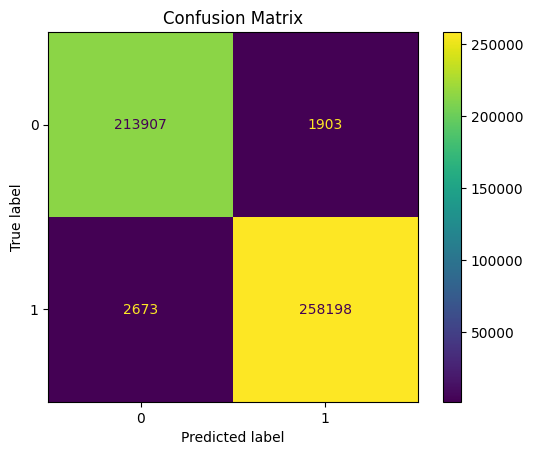

In [38]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X_train, X_test, y_train, y_test)

In [41]:
# cat_clf = CatBoostClassifier(
#     cat_features=categorical_columns,
#     verbose=False,
#     allow_writing_files=False,
#     task_type="GPU"
# )

# model_report(cat_clf, X_train, X_test, y_train, y_test)

    Model: LGBMClassifier
F1 Score : 0.987896
MCC Score: 0.973356


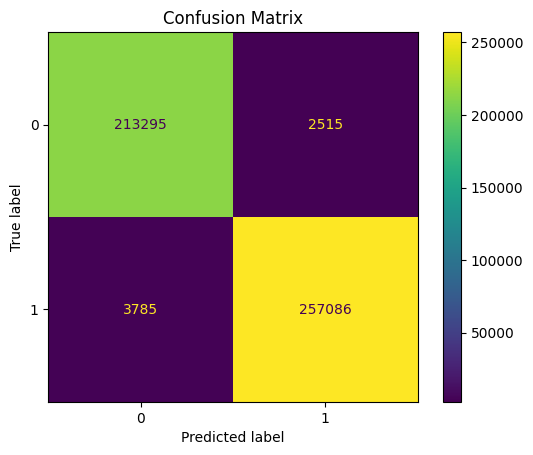

In [40]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X_train, X_test, y_train, y_test)

In [40]:
es = xgb.callback.EarlyStopping(rounds=EARLY_STOPPING_ROUNDS, save_best=True,maximize=True, metric_name='mcc')

xgb_params_alpha = {
    "colsample_bytree":0.6
    , "max_depth":16
    , "min_child_weight":7
    , "n_estimators":200
    , "learning_rate":0.1
    , "gamma": 0
    , "subsample":0.8
    , "reg_alpha":0.005
    , "reg_lambda":1
}

xgb_model_alpha = XGBClassifier(
    **xgb_params_alpha
    ,random_state=RANDOM_STATE
    ,callbacks=  [es]
    )

xgb_trained_model_alpha= xgb_model_alpha.fit(
    train_X,
    train_y,
    eval_set=[(test_X, test_y)],
    metric_name=mcc_metric)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'metric_name'

In [63]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_columns
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [45]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [64]:
# oof_probs에 XGBoost 모델 추가
oof_probs = {}

# XGBoost 모델의 OOF 확률과 MCC 점수 계산
oof_probs['xgb'], oof_mccs = model_trainer(
    xgb_params,  # XGBoost 모델 객체
    X_train, X_test, y_train, y_test,           # 테스트 데이터 (예측할 데이터프레임)
    random_state=RANDOM_STATE
)

oof_probs['lgb'], oof_mccs = model_trainer(
    xgb_params,  # XGBoost 모델 객체
    train_X,          # 전체 훈련 데이터
    train_y,          # 전체 라벨 데이터
    test_X,           # 테스트 데이터 (예측할 데이터프레임)
    random_state=RANDOM_STATE
)


Training dict


AttributeError: 'dict' object has no attribute 'fit'

In [57]:
oof_probs = {}
# oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X_train, X_test, y_train, y_test, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X_train, X_test, y_train, y_test, test_df, random_state=101)

Training LGBMClassifier


KeyError: '[3126808, 3129923, 3173478, 3173521, 3173527, 3173582, 3173608, 3173615, 3173635, 3173644, 3173649, 3173652, 3173674, 3173687, 3173694, 3173708, 3173740, 3173745, 3173746, 3173747, 3173755, 3173758, 3173761, 3173777, 3174540, 3174610, 3174611, 3174705, 3174732, 3174791, 3174810, 3174873, 3174878, 3174886, 3174889, 3174899, 3174903, 3174906, 3174910, 3174914, 3174916, 3174923, 3174931, 3174932, 3174938, 3174942, 3174956, 3174957, 3174959, 3174963, 3174987, 3174994, 3174996, 3175001, 3175005, 3175010, 3175018, 3175022, 3175024, 3175027, 3175032, 3175036, 3175039, 3175040, 3175054, 3175061, 3175064, 3175065, 3175066, 3175068, 3175070, 3175075, 3175076, 3175081, 3175082, 3175083, 3175085, 3175088, 3175089, 3175091, 3175092, 3175094, 3175096, 3175097, 3175099, 3175100, 3175101, 3175104, 3175106, 3175108, 3175110, 3175111, 3175112, 3175114, 3175115, 3175119, 3175120, 3175121, 3175123, 3175135, 3175138, 3175140, 3175142, 3175144, 3175145, 3175150, 3175157, 3175158, 3175163, 3175166, 3175167, 3175169, 3175170, 3175171, 3175175, 3175177, 3175178, 3175181, 3175182, 3175184, 3175186, 3175187, 3175189] not in index'

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

# Hyperparameter Tuning

In [ ]:
# import optuna
# from optuna.samplers import TPESampler

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, shuffle=True, stratify=y, random_state=101)

In [ ]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 2000, 3000),
#         "eta": trial.suggest_float("eta", 1e-3, 1e-2),
#         "gamma": trial.suggest_float("gamma", 0, 5.0),
#         "max_depth": trial.suggest_int("max_depth", 2, 32),
#         "min_child_weight": trial.suggest_int("min_child_weight", 40, 100),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         "max_leaves": trial.suggest_int("max_leaves", 16, 84)
#     }
#     params['device'] = 'cuda'
#     params['tree_method'] = 'hist'
#     params['enable_categorical'] = True

#     model = XGBClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "xgb"
# storage = "sqlite:///xgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
# #                             sampler=TPESampler(),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)


In [ ]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 3000),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#         "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         "od_wait": trial.suggest_int("od_wait", 10, 50),
#         "verbose": False,
#         "allow_writing_files": False,
#         "task_type": 'GPU',
#         "cat_features": categorical_features
#     }

#     model = CatBoostClassifier(**params)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "cat"
# storage = "sqlite:///cat.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                             sampler=TPESampler(n_startup_trials=20, multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=50)

# print(study.best_params)

In [ ]:
# def objective(trial):
#     params = {
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "device": 'gpu',
#         "verbosity": -1
#     }

#     model = LGBMClassifier(**params)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "lgb"
# storage = "sqlite:///lgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                             sampler=TPESampler(n_startup_trials=20, multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)

# Submission

In [ ]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
preds = [pred for model, pred in oof_preds.items()]
md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)

In [ ]:
ext1 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[target].ravel()
ext2 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[target].ravel()
ext3 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[target].ravel()
ext4 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[target].ravel()
ext5 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[target].ravel()

In [ ]:
preds = [ext1, ext2, ext3, ext4, ext5]

preds = [lab_enc.transform(x) for x in preds]

In [ ]:
md = mode(preds, axis=0)[0]

In [ ]:
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)